# Self Driving Car Engineer Nanodegree
## Project 3 - Behavioural Cloning
### Vilas Chitrakaran, Feb 2017

## Introduction
__TODO__

In [1]:
# Load the input data meta file
import os
import csv

# Read the CSV file in
# note: first line of the CSV file is the header. Add a column for flags as we read the file in
samples = []
with open('./sample_data/driving_log.csv') as csvfile:
    reader = csv.reader(csvfile)
    for line in reader:
        line.extend('0') # add a column for flags
        samples.append(line)

samples[0][-1] = 'flags' # last column is flags

print('Number of samples: ', len(samples)-1)
print('Data format: ', samples[0]) 

# Don't need the header anymore
samples.pop(0)

Number of samples:  8036
Data format:  ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed', 'flags']


['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed', 'flags']

Training images have:  160 rows, 320 columns, 3 channels
Steering range: ( -0.942695 , 1.0 )


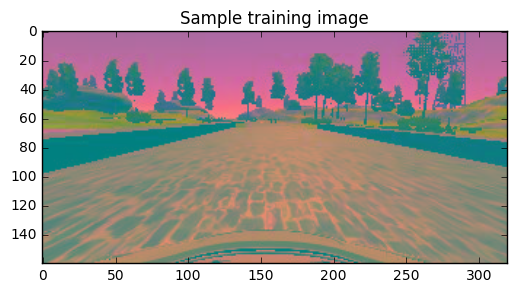

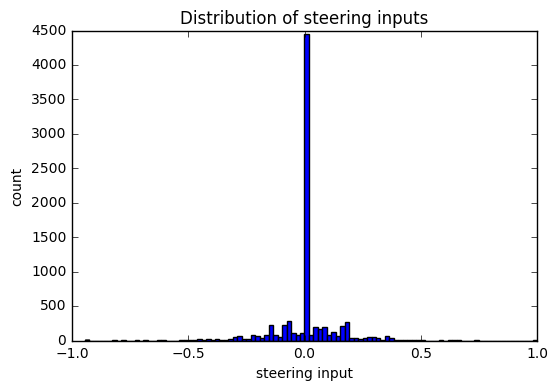

In [2]:
# Visualise steering distributions
# Note: Not sure what units they are in. If it's 'angle', it's most likely to be radians
# Note: NVidia paper uses inverse radius 1/r for steering input

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

def read_image(filename):
    image = cv2.imread(filename)
    return cv2.cvtColor(image,cv2.COLOR_BGR2YUV)

def plot_steering_distribution(dataset, title):
    steering = [np.float32(x[3]) for x in dataset]
    print('Steering range: (', min(steering), ',', max(steering), ')')
    plt.figure()
    plt.hist(steering, bins=101)
    plt.xlabel('steering input')
    plt.ylabel('count')
    plt.title(title)
    plt.show()

center_image_names = ['./sample_data/IMG/'+x[0].split('/')[-1] for x in samples]
left_image_names = ['./sample_data/IMG/'+x[1].split('/')[-1] for x in samples]
right_image_names = ['./sample_data/IMG/'+x[2].split('/')[-1] for x in samples]

sample_image = read_image(center_image_names[0])
imrows, imcols, imch = sample_image.shape

print('Training images have: ', imrows, 'rows,', imcols, 'columns,', imch, 'channels')
plt.figure()
plt.imshow(sample_image)
plt.title('Sample training image')
plot_steering_distribution(samples, 'Distribution of steering inputs')


Number of samples after cull: 3893
Steering range: ( -0.942695 , 1.0 )


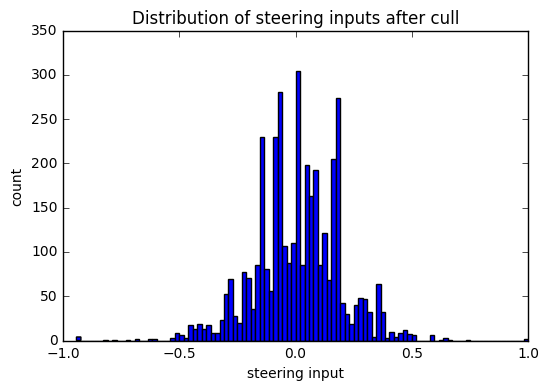

Number of samples after adding flipped images: 7786
Steering range: ( -1.0 , 1.0 )


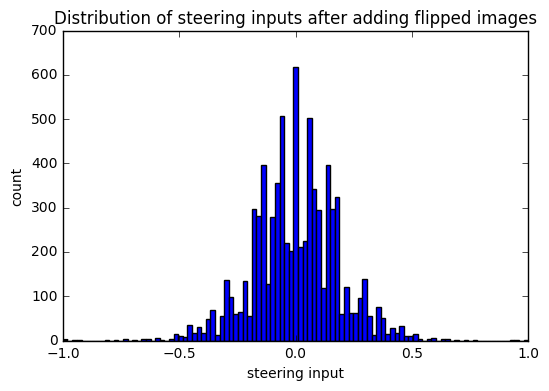

In [3]:
# Preprocess input data to make it more useful

import random
import copy

# reduce the large set of instances where steering is zero or close to.
def cull_steering_range(samples, keep_ratio = 0.1, min_steer=-0.001, max_steer=0.001):
    steer_active = [row for row in samples if (min_steer > float(row[3]) or float(row[3]) > max_steer)]
    steer_inactive = [row for row in samples if (min_steer <= float(row[3]) and float(row[3]) <= max_steer)]
    random_steer_inactive = random.sample(steer_inactive, int(keep_ratio * len(steer_inactive)))
    steer_active.extend(random_steer_inactive)
    return steer_active

culled_samples = cull_steering_range(samples,keep_ratio=0.05)
print('Number of samples after cull:', len(culled_samples))
plot_steering_distribution(culled_samples, 'Distribution of steering inputs after cull')

# augment data with flipped images and angles
def set_flip_flag(samples, flip_ratio=0.5):
    selected = random.sample(samples, int(flip_ratio * len(samples)))
    for row in selected:
        row[3] = "{}".format(-1*float(row[3]))
        row[7] = 'f' # set the flag here. Flip the image online within the generator
    return samples

valid_samples = culled_samples
valid_samples.extend(set_flip_flag(copy.deepcopy(culled_samples), flip_ratio=0.95))

print('Number of samples after adding flipped images:', len(valid_samples))
plot_steering_distribution(valid_samples, 'Distribution of steering inputs after adding flipped images')

# Increase data by using left images and damping left steers and enhancing right steers
# TODO

# Increase data by using right images and damping right steers and enhancing left steers
# TODO


In [4]:
# split data into training and validation sets
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

shuffle(samples)
train_samples, validation_samples = train_test_split(valid_samples, test_size=0.2)
print('Number of training samples:', len(train_samples))
print('Number of validation samples:', len(validation_samples))

Number of training samples: 6228
Number of validation samples: 1558


In [5]:
# Generator function to avoid loading all images and data into memory

def flip_image(image):
    image = np.fliplr(image)
    return image

def generate_batch(samples, batch_size):
    num_samples = len(samples)
    while 1:
        shuffle(samples)
        for offset in range(0, num_samples, batch_size):
            batch_samples = samples[offset:offset+batch_size]

            images = []
            angles = []
            for sample in batch_samples:
                image = read_image('./sample_data/IMG/'+sample[0].split('/')[-1])
                if sample[7] is 'f':
                    image = flip_image(image) # angles are already flipped
                images.append(image)
                angles.append(np.float32(sample[3]))
                
            # trim image to only see section with road
            X_train = np.array(images)
            y_train = np.array(angles)
            yield shuffle(X_train, y_train)

Batch: 0 , num images:  32 , num angles: 32
Batch: 1 , num images:  32 , num angles: 32
Batch: 2 , num images:  32 , num angles: 32
Batch: 3 , num images:  32 , num angles: 32


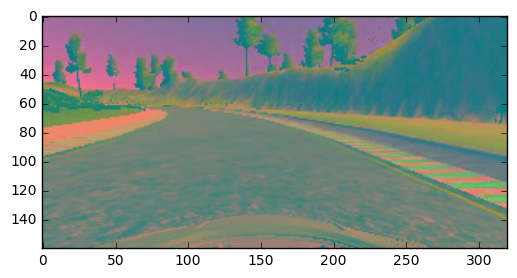

In [6]:
# Test the generator
ntest = 4
for i in range(ntest):
    image, angle = next(generate_batch(train_samples, batch_size=32))
    print('Batch:', i,', num images: ', len(image), ', num angles:', len(angle))

plt.figure()
plt.imshow(image[0])

In [ ]:
# Define network
# We implement CNN architecture from the nvidia paper with a few modifications 
# (added relu activations, max-pooling and drop-outs)

from keras.models import Sequential
from keras.layers import Cropping2D
from keras.layers.core import Lambda, Dense, Activation, Flatten, Dropout
from keras.layers.convolutional import Convolution2D
from keras.layers.pooling import MaxPooling2D

# generate the neural network
model = Sequential()
model.add(Cropping2D(cropping=((60,20), (0,0)), input_shape=(imrows, imcols, imch))) # crop to track
model.add(Lambda(lambda x: x/127.5 - 1.)) # normalise
model.add(Convolution2D(24, 5, 5, activation=None, subsample=(1,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(36, 5, 5, activation=None, subsample=(1,1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Convolution2D(48, 5, 5, activation='relu', subsample=(2,2)))
model.add(Convolution2D(64, 3, 3, activation=None, subsample=(2,2)))
model.add(Convolution2D(64, 3, 3, activation=None, subsample=(1,1)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(100))
model.add(Dense(50))
model.add(Dense(10))
model.add(Dense(1))

# print a summary of the NN
model.summary()


Using TensorFlow backend.


____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
cropping2d_1 (Cropping2D)        (None, 80, 320, 3)    0           cropping2d_input_1[0][0]         
____________________________________________________________________________________________________
lambda_1 (Lambda)                (None, 80, 320, 3)    0           cropping2d_1[0][0]               
____________________________________________________________________________________________________
convolution2d_1 (Convolution2D)  (None, 76, 316, 24)   1824        lambda_1[0][0]                   
____________________________________________________________________________________________________
maxpooling2d_1 (MaxPooling2D)    (None, 38, 158, 24)   0           convolution2d_1[0][0]            
___________________________________________________________________________________________

In [ ]:
# compile and train the model using the generator function
EPOCHS = 5
BATCH_SIZE = 128

train_generator = generate_batch(train_samples, batch_size=BATCH_SIZE)
validation_generator = generate_batch(validation_samples, batch_size=BATCH_SIZE)

model.compile(loss='mse', optimizer='adam')
model.fit_generator(train_generator, samples_per_epoch=len(train_samples), 
                    validation_data=validation_generator, nb_val_samples=len(validation_samples), 
                    nb_epoch=EPOCHS)

Epoch 1/5
 768/6228 [==>...........................] - ETA: 139s - loss: 0.0352

In [ ]:
# Save the model and weights
from keras.models import load_model
model.save("./model.h5")
print("Saved model to disk")